In [1]:
import numpy as np
import sys

sys.path.append("/vols/talos/home/stephan/utils/tracking")
import tracking_common as tc

import l15_msevi.msevi as msv

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
s = msv.MSevi(time=dt.datetime(2012,7,28,12,0),chan_list=['IR_108','HRV'])
s.lonlat()
s.rad2bt()
s.rad2refl()

Region suggests use of hdf file


In [3]:
cma = msv.MSGtools.get_nwcsaf_prod('CMa',dt.datetime(2012,7,28,12,0),calibrate=True)

Um bessere Aufpunkte für die Segmentierung zu finden, wäre es gut die Schwerpunkte der Pixel mit den höchsten oder niedrigsten Werten zu benutzen. Die Grundidee ist nur den Bereich über oder unter einem Schwellwert zu benutzen und für diesen dann Gewichte zu berechnen. Die Pixel mit den höchsten Werten bekommen dann den Punkt zugewiesen.

Dafür transformieren wir zunächst die Daten des IR-10,8-µm-Kanals so, dass die Minima zu Maxima werden.

In [4]:
ir_trans = np.max(s.bt['IR_108']) - s.bt['IR_108']

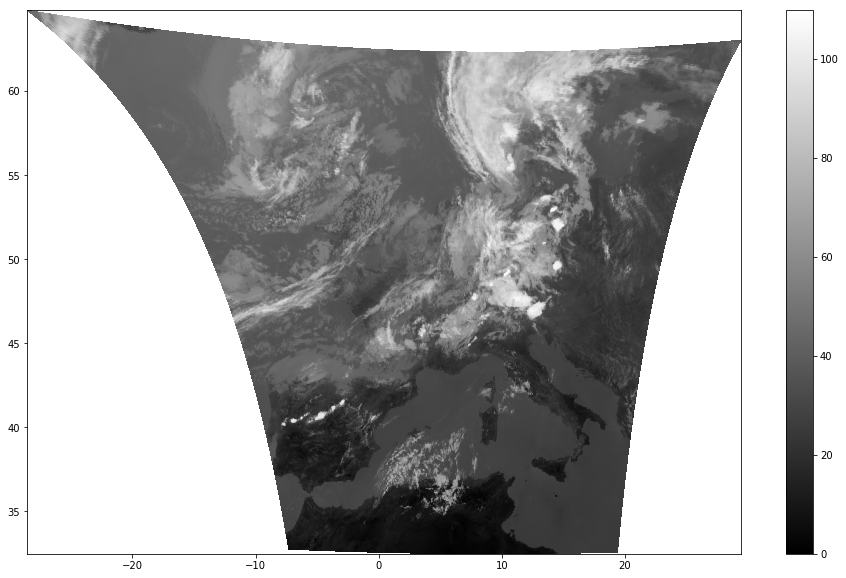

In [5]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,ir_trans,vmin=0,vmax=np.max(ir_trans),cmap='gray')
plt.colorbar(ir_plot)

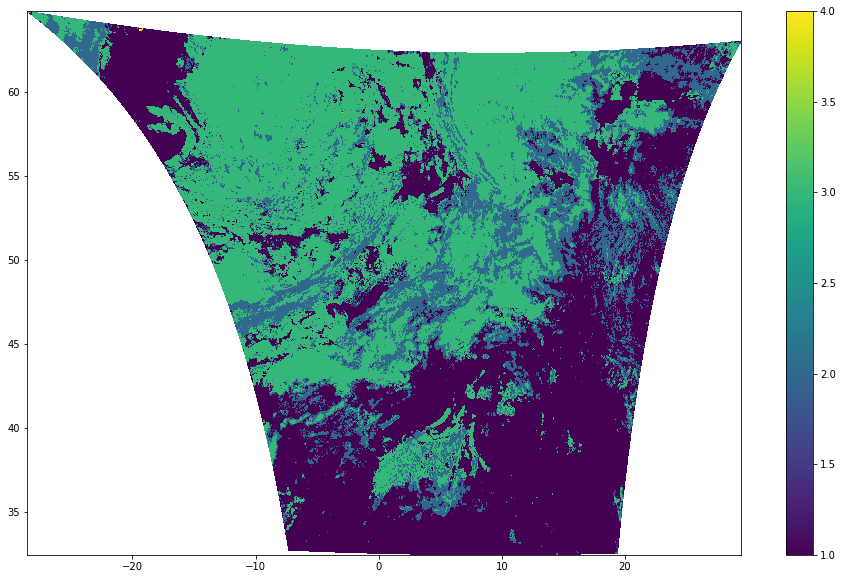

In [6]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,cma)
plt.colorbar(ir_plot)

Danach legen wir einen Schwellwert fest und weisen allen Pixeln mit Werten unterhalb des Schwellwertes den Wert null zu. Die Pixel oberhalb des Schwellwertes normieren wir mit dem Maximum, damit der Wertebereich im Intevall [0;1] liegt. Besser als ein einzelner Schwellwert ist es, eine Wolkenmaske zu verwenden. Wir setzten einfach alle Werte ohne Wolken auf 0.

In [7]:
ir_masked = ir_trans.copy()

ir_masked[np.where(cma==1)] = 0 
not_zero = np.where(ir_masked > 0)

ir_masked[not_zero] = ir_masked[not_zero] / np.max(ir_masked)

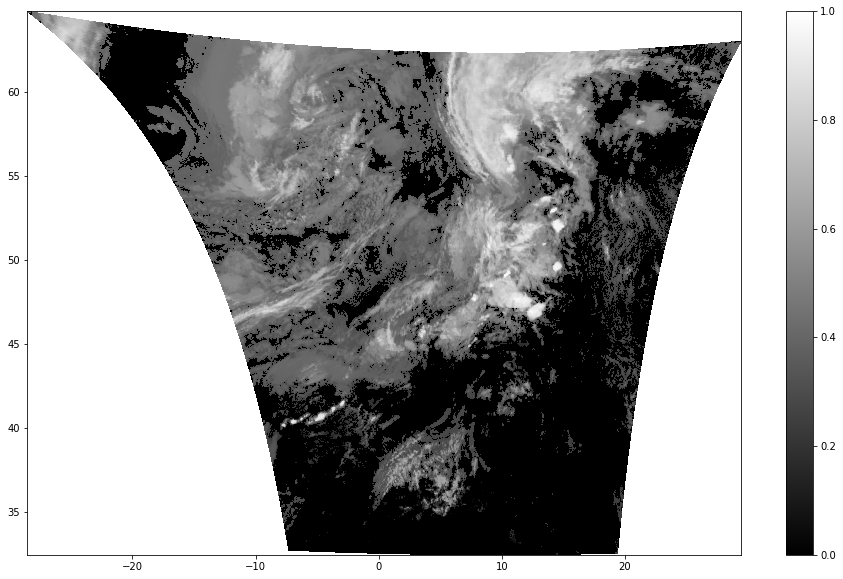

In [8]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,ir_masked,vmin=0,vmax=1,cmap='gray')
plt.colorbar(ir_plot)

Als nächstes Ermitteln wir die Gewichte wie folgt:

$w_i = \frac{\hat{f_i^\alpha}}{\sum\limits_{i=1}^n \hat{f_i^\alpha}}$

und setzten $\alpha$ erstmal auf 2. Mit höheren Werten können die Maxima noch stärker betont werden.

In [9]:
alpha=2
weights = ir_masked**alpha / np.sum(ir_masked**alpha)

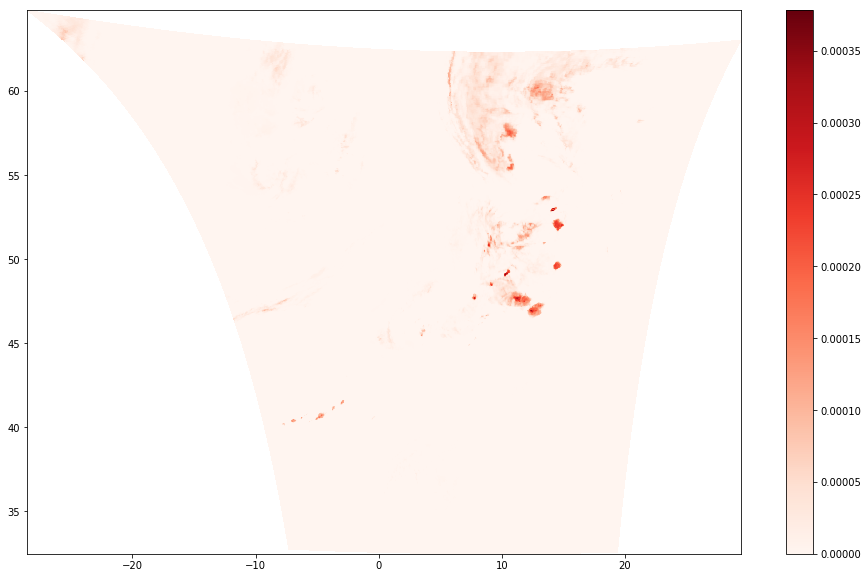

In [10]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,weights,vmin=np.min(weights),vmax=np.max(weights),cmap='Reds')
plt.colorbar(ir_plot)

Danach multplizieren wir die Gewichte mit der maskierten Matrix.

In [11]:
g = ir_masked * weights

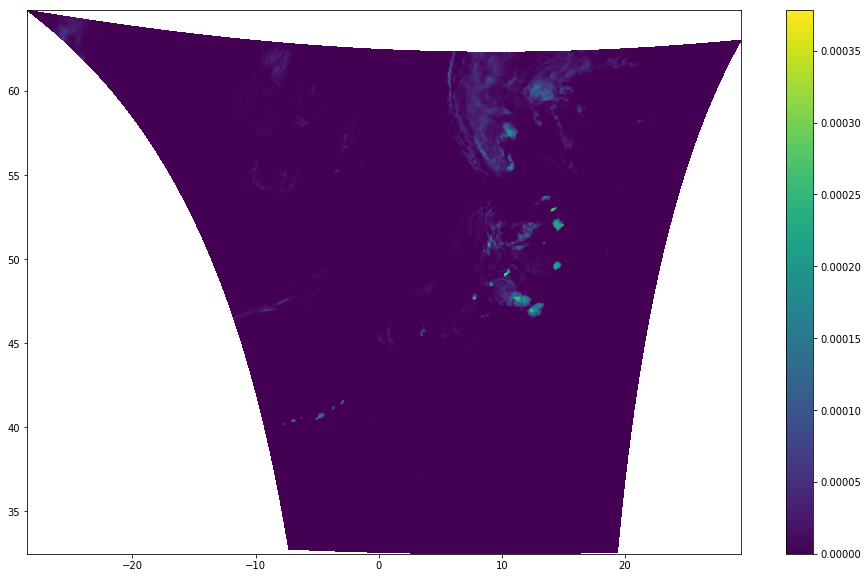

In [12]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,g)
plt.colorbar(ir_plot)

Die Bereiche mit Maxima, sind diejenigen, die uns interessieren. Das sind zwar wahrscheinlich bereits konvektive W
Wolken in späteren Stadien, aber als Startpunkt kann man sie eventuell verwenden. Dazu müssen wir die lokalen Maxima finden.

In [13]:
import scipy.ndimage as ndi
import scipy.ndimage.filters as filters

In [14]:
data_max = filters.maximum_filter(g, 5)
maxima = (g == data_max)
data_min = filters.minimum_filter(g, 11)
diff = ((data_max - data_min) > 0.0002)
maxima[diff == 0] = 0

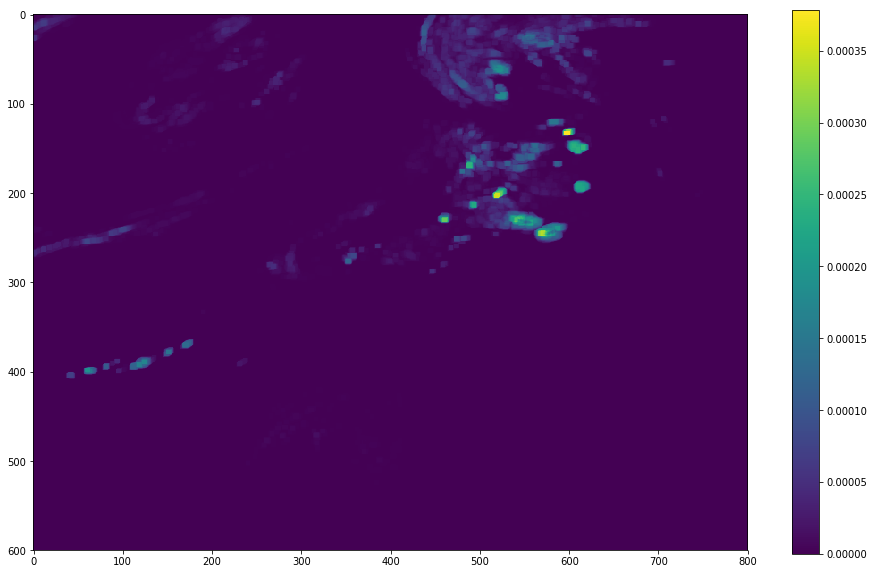

In [15]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
diff_plot = ax.imshow(data_max - data_min)
plt.colorbar(diff_plot)

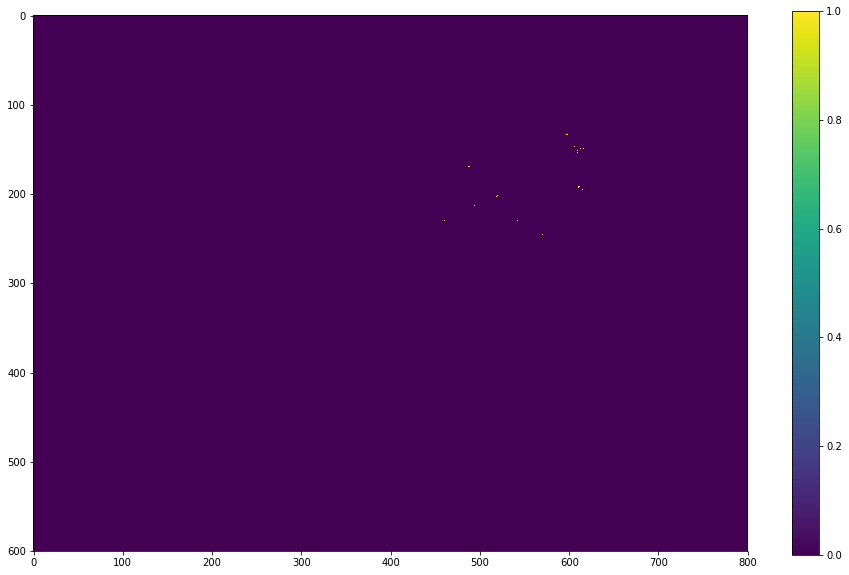

In [16]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
diff_plot = ax.imshow(maxima*1)
plt.colorbar(diff_plot)

In [17]:
labeled, num_objects = ndi.label(maxima)
xy = np.array(ndi.center_of_mass(g, labeled, range(1, num_objects+1)))

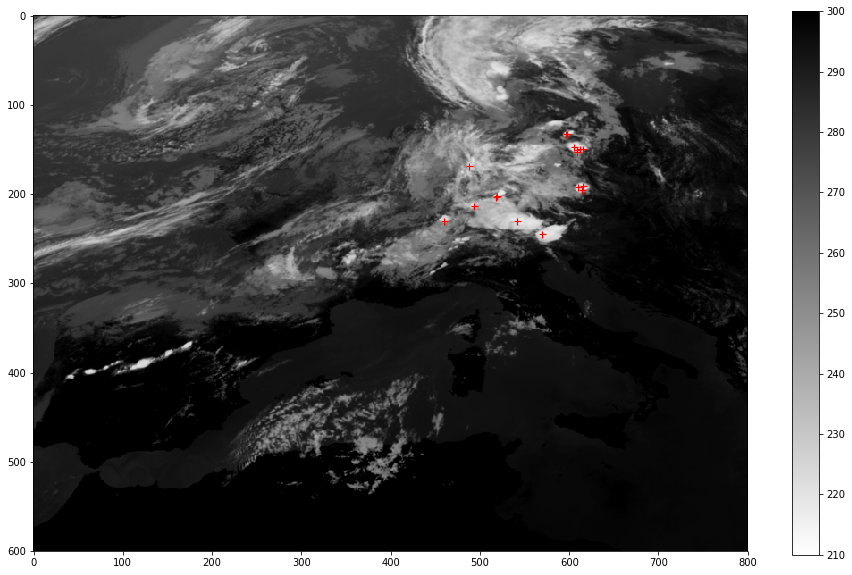

In [18]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.imshow(s.bt['IR_108'],vmin=210,vmax=300,cmap='gray_r')
plt.colorbar(ir_plot)
ax.plot(xy[:,1],xy[:,0],'r+',markersize='7',mew=1.2)

Das sieht recht gut aus, nur wäre es schöner nur einen Punkt pro konvektiver Wolke zu haben.

In [19]:
def quantise_field(field,lower_limit,upper_limit,delta):
    """
    Quantises a given array into discrete steps within given limits and step width.
    
    Parameters
    ----------
    field: numpy array, 2d
        array to quantise
    limit1: float
        first limit for the quantisation
    limit2: float
        second limit for the quantisation
    delta: float
        width of the quantisation steps, if delta > 0 the quantisation will be based on the field maxima and if it
        it < 0 on the field minima
    """
    
    quant = np.zeros_like(field)
    
    too_small = np.where(field <= lower_limit)
    too_large = np.where(field > upper_limit)
    right = np.where(np.logical_and(field > lower_limit,field <= upper_limit) )
    
    if delta < 0:
        quant[too_small] = np.rint((lower_limit-upper_limit)/ delta)
        quant[too_large] = 0
        quant[right] = np.rint((field[right] - upper_limit) / delta)
        
        return quant
    elif delta > 0:
        quant[too_large] = np.rint((upper_limit-lower_limit)/ delta)
        quant[too_small] = 0
        quant[right] = np.rint((field[right] - lower_limit) / delta)
        
        return quant
    else:
        print("Impossible combination. If limit1 > limit2, delta has to be < 0 and if limit1 < limit2, delta has to be negative.")
        return

In [20]:
ir_quant = quantise_field(ir_masked,np.min(ir_masked),np.max(ir_masked),0.1)

In [21]:
np.max(ir_masked)

1.0

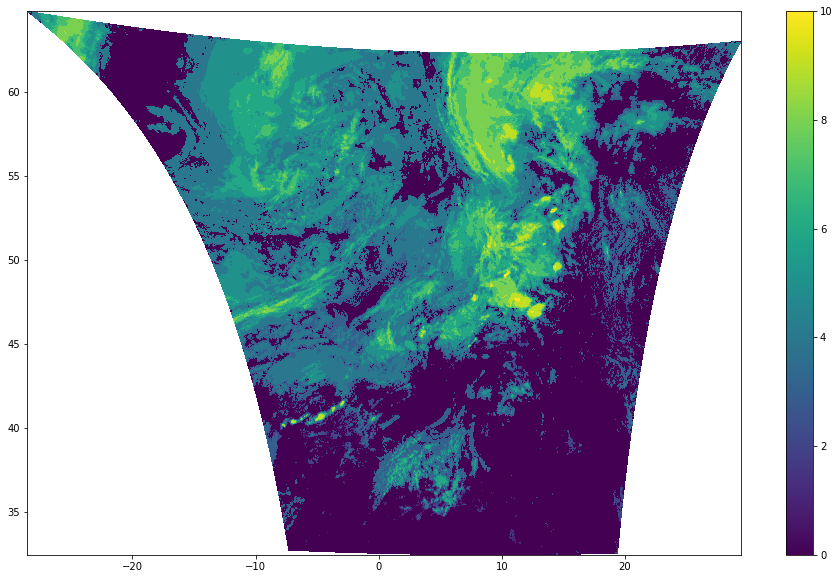

In [22]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,ir_quant)
plt.colorbar(ir_plot)

In [23]:
alpha=3
weights = ir_quant**alpha / np.sum(ir_quant**alpha)

g = ir_quant * weights

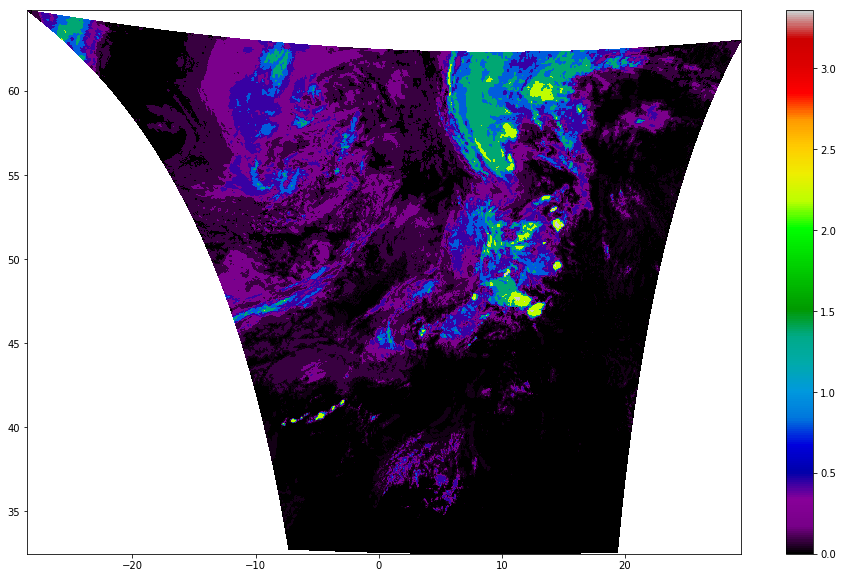

In [24]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,g*10000,cmap='nipy_spectral')
plt.colorbar(ir_plot)

In [25]:
np.max(g)

0.0003359990941464422

In [26]:
g_quant = quantise_field(g,np.min(g),np.max(g),0.00001)

In [27]:
g_values = np.unique(g_quant)
g_new = np.zeros_like(g)

In [28]:
for i,value in enumerate(g_values):
    idx = np.where(g_quant == value)
    
    g_new[idx] = i

In [29]:
cmap = plt.cm.get_cmap('nipy_spectral',len(np.unique(g_quant)))

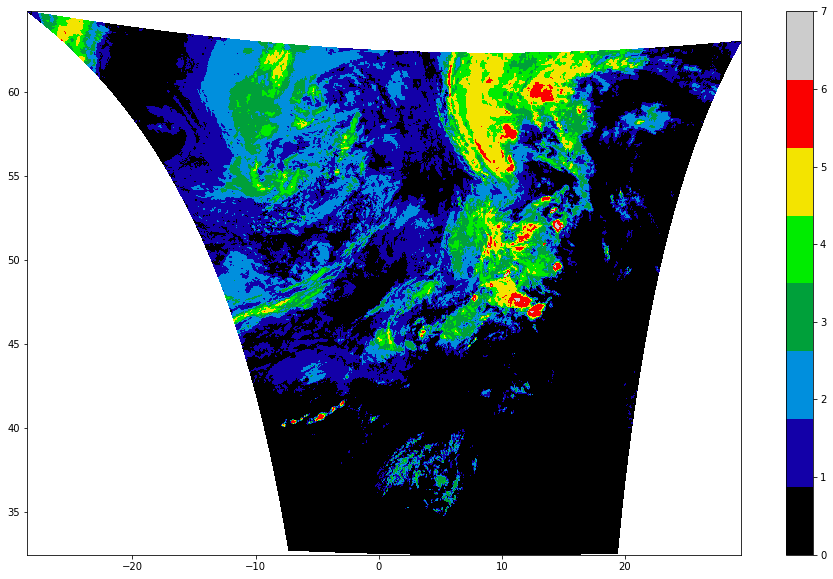

In [30]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,g_new,vmin=np.min(g_new),vmax=np.max(g_new),cmap=cmap)
plt.colorbar(ir_plot)

Es sieht so aus, als könnten die Pixel mit den Werten 7 und 6 sinvolle Objekte sein. Objekte mit beiden sind besonders hochreichende Wolken und damit am ehesten konvektive Wolken in späteren Stadien oder besonders schnell wachsende Wolken.

In [31]:
g_max = np.zeros_like(g)

max_idx = np.where(g_new==np.max(g_new))

g_max[max_idx] = 2

idx = np.where(g_new == 6)
g_max[idx] = 1

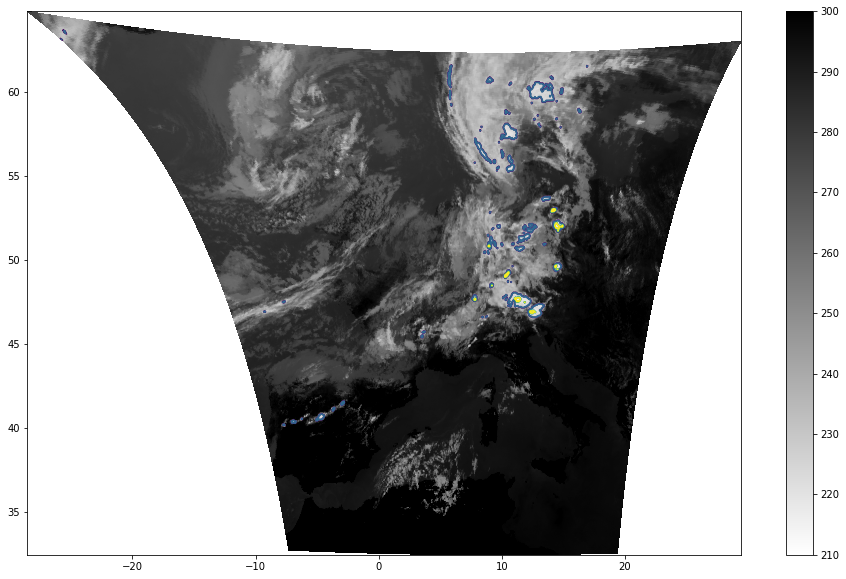

In [32]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ir_plot = ax.pcolormesh(s.lon,s.lat,s.bt['IR_108'],vmin=210,vmax=300,cmap='gray_r')
plt.colorbar(ir_plot)
class_plot = ax.contour(s.lon,s.lat,g_max)

## Kombination aus HRV und IR

Vielleicht kann man die möglichen Objekte in den Frontalzonen entfernen, wenn man sichtbare und IR-Informationen verbindet. Ein Ansatz wäre das so ähnlich wie Zinner et al. (2008) zu machen.

In [33]:
from analysis_tools.grid_and_interpolation import make_hrv_upscaling as mhs

tlist = [dt.datetime(2012,7,28,11,40),
         dt.datetime(2012,7,28,11,45),
         dt.datetime(2012,7,28,11,50),
         dt.datetime(2012,7,28,11,55),
         dt.datetime(2012,7,28,12,0)]

channels = ['HRV','IR_108','WV_062']
sat_data = {ch:{t.strftime('%Y%m%dt%H%M'):[] for t in tlist} for ch in channels}
cma = dict()

for t in tlist:
    s = msv.MSevi(time=t,chan_list = channels)
    s.lonlat()
    s.rad2bt()
    s.rad2refl()
        
    sat_data['IR_108'][t.strftime('%Y%m%dt%H%M')] = mhs(s.bt['IR_108'])
    sat_data['WV_062'][t.strftime('%Y%m%dt%H%M')] = mhs(s.bt['WV_062'])
    sat_data['HRV'][t.strftime('%Y%m%dt%H%M')] = s.ref['HRV']
    
    cm = msv.MSGtools.get_nwcsaf_prod('CMa',t,calibrate=True)
    cm = mhs(cm)
    
    cma[t.strftime("%Y%m%dt%H%M")] = cm

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


 Als nächstes bestimmen wir die Bewegungsfelder zwischen den Zeitschritten.

In [34]:
import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import optical_flow_tracking as oft

from analysis_tools import optical_flow as oflow

import scipy.ndimage as ndi

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
flows = {ch:{'{}_{}'.format(tlist[i-1].strftime('%Y%m%dt%H%M'),tlist[i].strftime('%Y%m%dt%H%M')):[]
                            for i in xrange(1,len(tlist))}
            for ch in channels[1:]}

In [36]:
fill_values = {'HRV':0,'IR_108':np.nan,'WV_062':np.nan}

for ch in channels[1:]:
    for i in xrange(1,len(tlist)):
        t0 = tlist[i-1].strftime("%Y%m%dt%H%M")
        t1 = tlist[i].strftime("%Y%m%dt%H%M")
        
        cloud_free_idx_t0 = np.where(cma[t0] < 2)
        cloud_free_idx_t1 = np.where(cma[t1] < 2)
        
        field_t0 = sat_data[ch][t0] 
        field_t1 = sat_data[ch][t1]
        
        field_t0[cloud_free_idx_t0] = fill_values[ch]
        field_t1[cloud_free_idx_t1] = fill_values[ch]
        
        field_t0 = ndi.uniform_filter(field_t0,25)
        field_t1 = ndi.uniform_filter(field_t1,25)
        
        flow = oft.calculate_optical_flow([field_t0,
                                           field_t1],'tvl1')
        flows[ch]["{}_{}".format(t0,t1)] = flow        

/home/lenk/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Und erstellen die Differenzfelder.

In [37]:
hrv_moved = oflow.morph_trans_opt_flow(sat_data['HRV']['20120728t1155'],
                                       flows['IR_108']['20120728t1155_20120728t1200'][0])

In [38]:
ir_moved = oflow.morph_trans_opt_flow(sat_data['IR_108']['20120728t1155'],
                                       flows['WV_062']['20120728t1150_20120728t1155'][0])

In [39]:
DHRV = sat_data['HRV']['20120728t1200'] - hrv_moved
DIR = sat_data['IR_108']['20120728t1200'] - ir_moved

Text(0.5,1,'$\\Delta$IR')

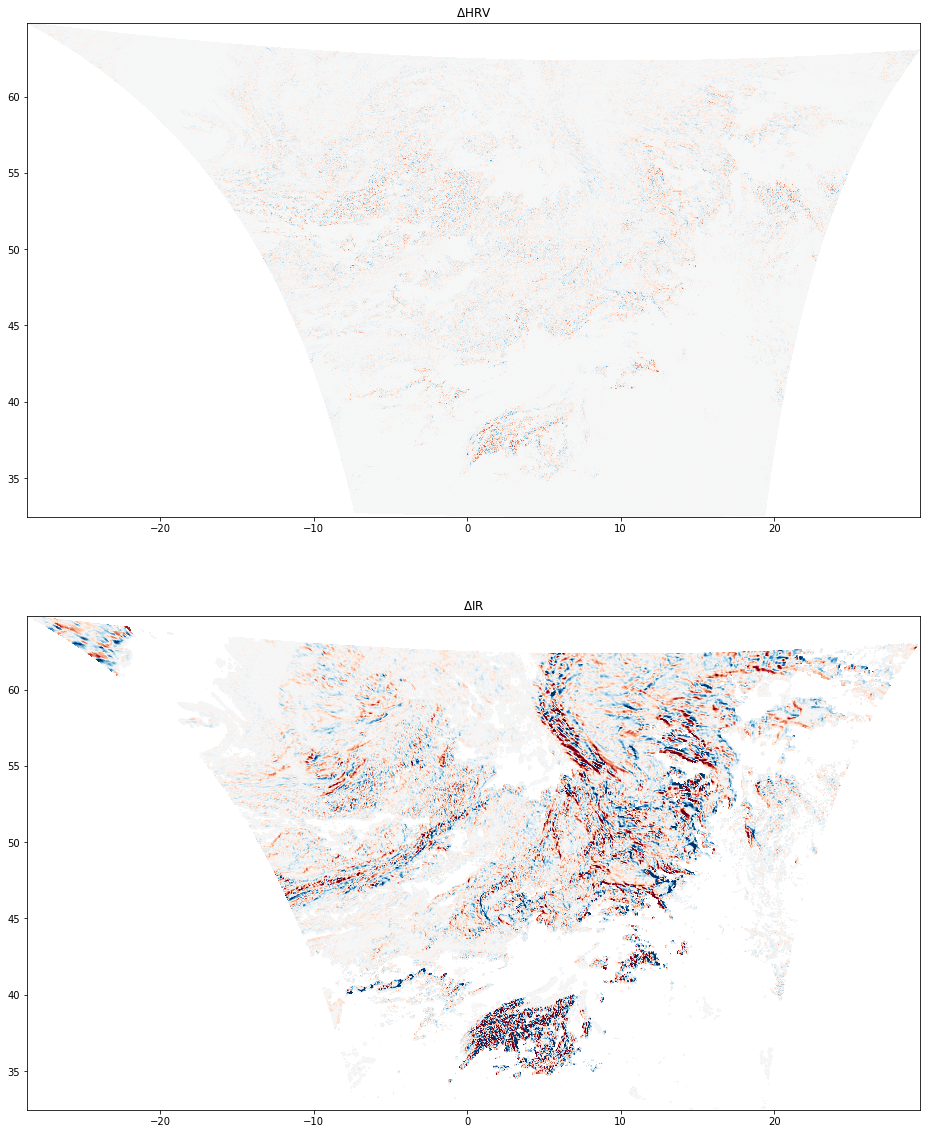

In [40]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].pcolormesh(s.hlon,s.hlat,DHRV,vmin=-1,vmax=1,cmap='RdBu_r')
ax[0].set_title(r"$\Delta$HRV")
ax[1].pcolormesh(s.hlon,s.hlat,DIR,vmin=-10,vmax=10,cmap='RdBu_r')
ax[1].set_title(r"$\Delta$IR")

Jetzt müssen wir die Differenzfelder normalisieren und mutliplizieren.

In [41]:
DIR[np.where(np.isnan(DIR))] = 0

DHRV_norm = tc.scale_array_min_max(DHRV,-1,1)
DIR_norm = tc.scale_array_min_max(DIR,-1,1)

indicator = -DHRV_norm * DIR_norm

In [42]:
indicator

array([[-1.62373427e-03, -1.26144672e-03, -1.30827511e-03, ...,
        -2.42593120e-04, -2.54760250e-03,  6.88448676e-04],
       [-2.14251599e-03, -2.38263703e-03, -1.82764613e-03, ...,
         1.94112611e-03,  5.16132990e-04,  6.14344325e-04],
       [-1.32233048e-03, -1.20022038e-03, -1.17969667e-03, ...,
         3.83022684e-03,  4.41462603e-03,  1.56675751e-03],
       ...,
       [ 5.20729241e-05,  5.28401203e-05,  1.86770673e-04, ...,
         7.60357173e-04, -2.66718881e-03, -8.13778833e-04],
       [ 1.85632605e-04, -1.42478100e-05, -1.26809870e-05, ...,
         4.87431341e-03,  9.30596994e-04, -1.28105175e-04],
       [ 5.38618914e-05,  1.19103371e-04,  5.31915920e-05, ...,
         9.23737987e-03,  6.63712073e-04, -9.46461908e-04]])

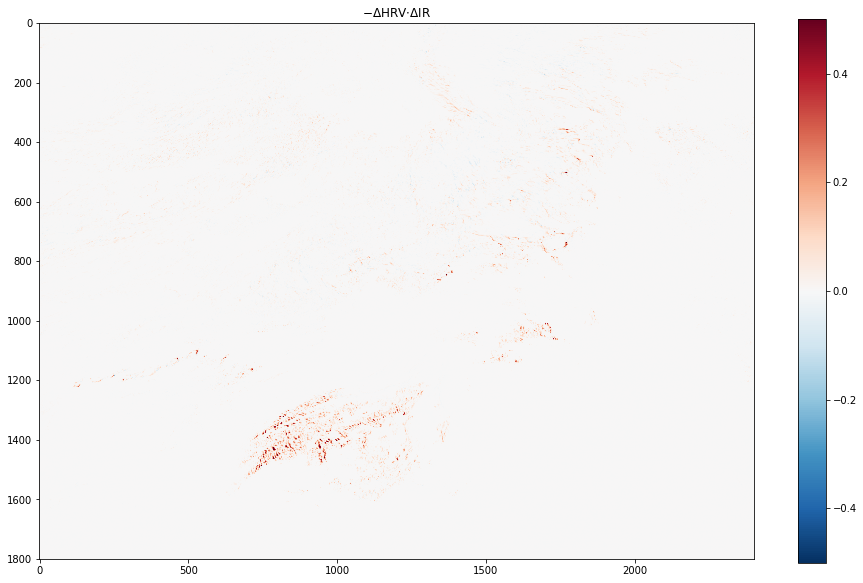

In [43]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ind_plot = ax.imshow(indicator,vmin=-0.5,vmax=0.5,cmap='RdBu_r')
ax.set_title(r"$-\Delta$HRV$\cdot \Delta$IR")
plt.colorbar(ind_plot)

In [44]:
DHRV_threshold = 3 * np.std(DHRV_norm)
DIR_threshold = -3 * np.std(DIR_norm)

indicator_threshold = -DHRV_threshold * DIR_threshold

In [45]:
indicator_threshold

0.037470201845301455

(array([5.000000e+00, 8.000000e+00, 1.200000e+01, 2.800000e+01,
        4.100000e+01, 4.600000e+01, 5.800000e+01, 1.010000e+02,
        1.310000e+02, 1.820000e+02, 2.570000e+02, 3.780000e+02,
        6.400000e+02, 8.190000e+02, 1.217000e+03, 1.769000e+03,
        2.496000e+03, 3.467000e+03, 5.399000e+03, 8.017000e+03,
        1.247800e+04, 2.119800e+04, 3.878500e+04, 7.526000e+04,
        1.786750e+05, 3.093321e+06, 5.566910e+05, 1.577530e+05,
        7.048500e+04, 3.661000e+04, 2.001200e+04, 1.230700e+04,
        7.631000e+03, 4.898000e+03, 3.265000e+03, 1.999000e+03,
        1.341000e+03, 8.460000e+02, 5.260000e+02, 3.030000e+02,
        2.010000e+02, 1.370000e+02, 1.030000e+02, 5.200000e+01,
        2.700000e+01, 1.500000e+01, 8.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([-45.11943059, -43.37961691, -41.63980323, -39.89998955,
        -38.16017586, -36.42036218, -34.6805485 , -32.94073481,
        -31.20092113, -29.46110745, -27.72129376, -25.98148008,
  

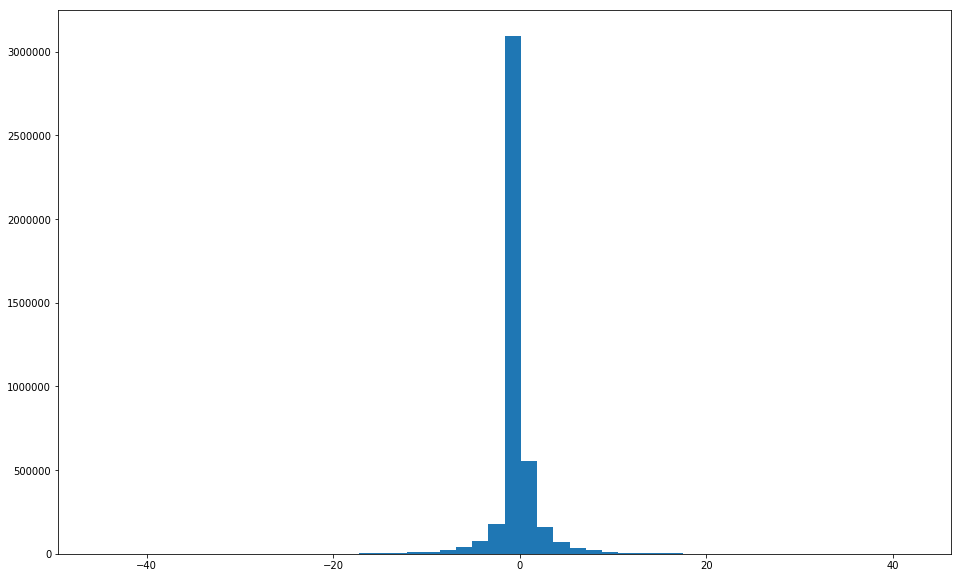

In [46]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.hist(DIR.ravel(),bins=50)

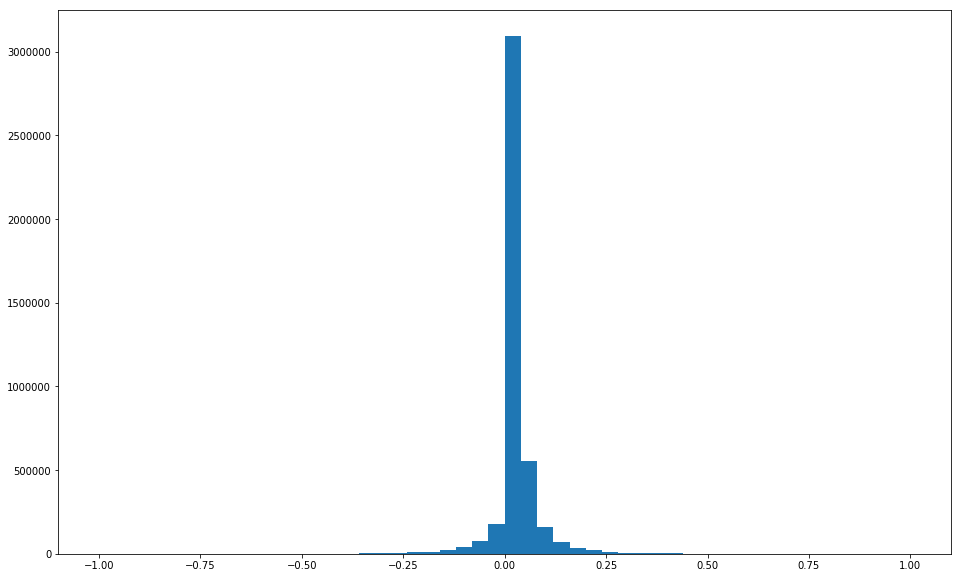

In [47]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
(xy) = ax.hist(DIR_norm.ravel(),bins=50)

In [48]:
print r"$\overline{x}_\mathrm{\Delta IR}$ = " + "{}".format(np.median(DIR))
print r"$\overline{x}_\mathrm{\Delta IR, normalisiert}$ = " + "{}".format(np.median(DIR_norm))

$\overline{x}_\mathrm{\Delta IR}$ = 0.0
$\overline{x}_\mathrm{\Delta IR, normalisiert}$ = 0.0373393665079


In [49]:
hrv_mask = np.ma.masked_less(sat_data['HRV']['20120728t1200'],0.5)

ind_mask = np.ma.masked_less(indicator,indicator_threshold)
combi_mask = ~hrv_mask.mask & ~ind_mask.mask

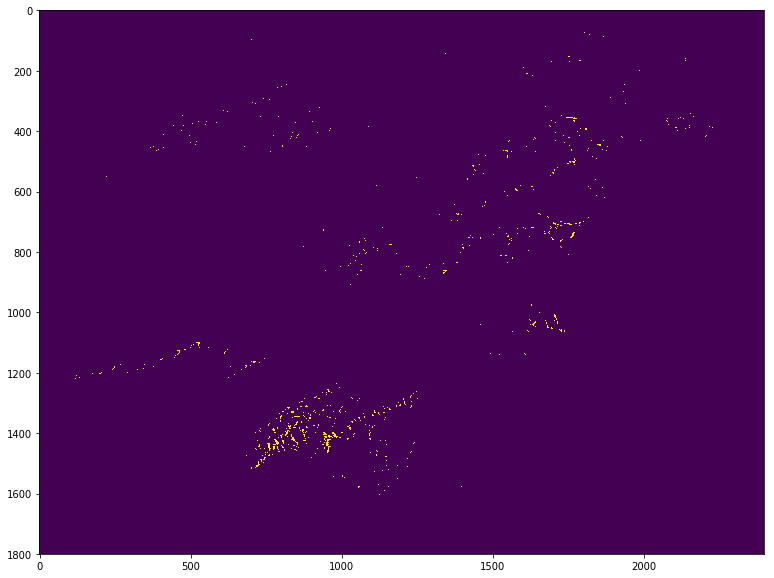

In [50]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(combi_mask*1)

Das sind ziemlich viele relativ kleine Bereiche mit wachsenden Wolken und ein Großteil liegt auch in Fronten. Vielleicht können wir die Segmentierung verbessern, indem wir wie oben vorgehen.

In [51]:
DHRV = dict()
DIR = dict()

indicator = dict()

indicator_thresholds = dict()

for i in xrange(1,len(tlist)):
    t0_str = tlist[i-1].strftime('%Y%m%dt%H%M')
    t1_str = tlist[i].strftime('%Y%m%dt%H%M')
    
    DIR_i = sat_data['IR_108'][t1_str] - oflow.morph_trans_opt_flow(sat_data['IR_108'][t0_str],
                                                                    flows['WV_062']["{}_{}".format(t0_str,t1_str)][0])
    
    DHRV_i = sat_data['HRV'][t1_str] - oflow.morph_trans_opt_flow(sat_data['HRV'][t0_str],
                                                                  flows['IR_108']["{}_{}".format(t0_str,t1_str)][0])
    
    cloud_free_idx = np.where(cma[t0_str]<2)
    
    DIR_i[cloud_free_idx] = 0
    DHRV_i[cloud_free_idx] = 0
    
    DIR_i[np.where(np.isnan(DIR_i))] = 0
    
    DIR_i = tc.scale_array_min_max(DIR_i,-1,1)
    DHRV_i = tc.scale_array_min_max(DHRV_i,-1,1)
    
    DIR[t1_str] = DIR_i
    DHRV[t1_str] = DHRV_i
    
    indicator[t1_str] = -DHRV_i * DIR_i
    
    indicator_thresholds[t1_str] = 3 * (-np.std(DHRV_i) * np.std(DIR_i))

In [52]:
indicator_thresholds


{'20120728t1145': -0.013040925196207137,
 '20120728t1150': -0.011645037301956965,
 '20120728t1155': -0.011787549891705548,
 '20120728t1200': -0.012321783143980409}

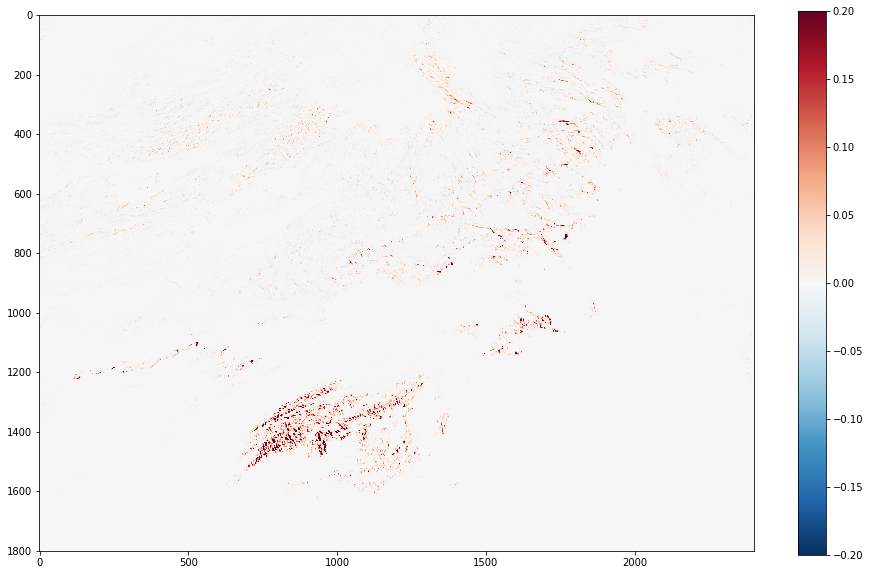

In [53]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ind_plot = ax.imshow(indicator['20120728t1200'],vmin=-0.2,vmax=0.2,cmap='RdBu_r')
plt.colorbar(ind_plot)

In [54]:
indicator_masked = dict()
indicator_weighted = dict()

alpha = 1
for key in indicator.keys():
    hrv_mask = np.ma.masked_less(sat_data['HRV'][key],0.5)
    
    ind_masked = indicator[key] * ~hrv_mask.mask*1
    
    idx_below_thresh = np.where(ind_masked < indicator_thresholds[key])
    
    ind_masked[idx_below_thresh] = 0
    
    ind_new = (ind_masked - indicator_thresholds[key]) / np.max(ind_masked)
    
    indicator_masked[key] = ind_new
    
    weights = ind_new**alpha / np.sum(ind_new)**alpha
    
    indicator_weighted[key] = weights * ind_new

In [55]:
indicator_quantised = dict()

for key in indicator_weighted.keys():
    indicator_quantised[key] = quantise_field(indicator_weighted[key],
                                         np.min(indicator_weighted[key]),
                                         np.max(indicator_weighted[key]),
                                         1e-6)

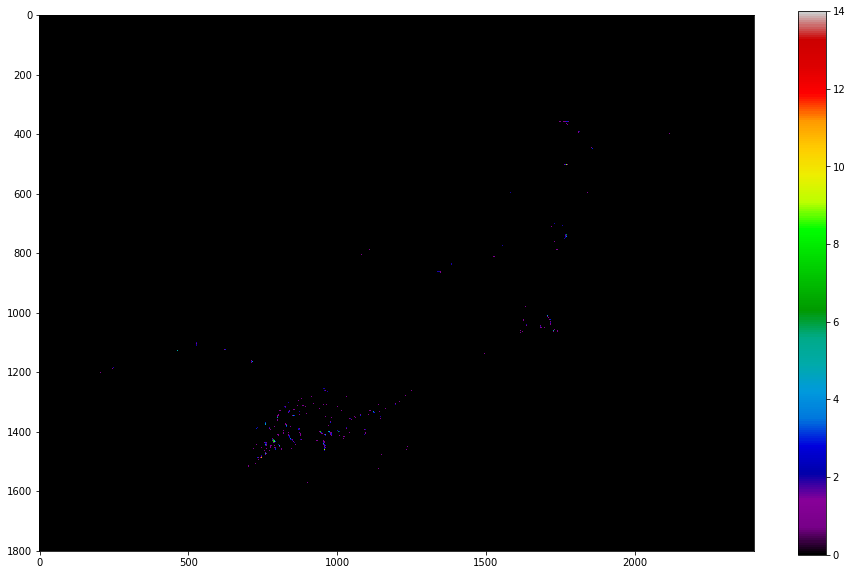

In [56]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ind_plot = ax.imshow(indicator_quantised['20120728t1200'],cmap='nipy_spectral')
plt.colorbar(ind_plot)

Jetzt bleiben nur noch ganz wenige Punkte mit hohen Werten übrig, aber der größte Teil der in Fronten liegenden "Objekte" konnte eliminiert werden.

In [57]:
results = dict()

for key in indicator_quantised.keys():
    masked = np.ma.masked_less(indicator_quantised[key],4)
    results[key] = ~masked.mask*1

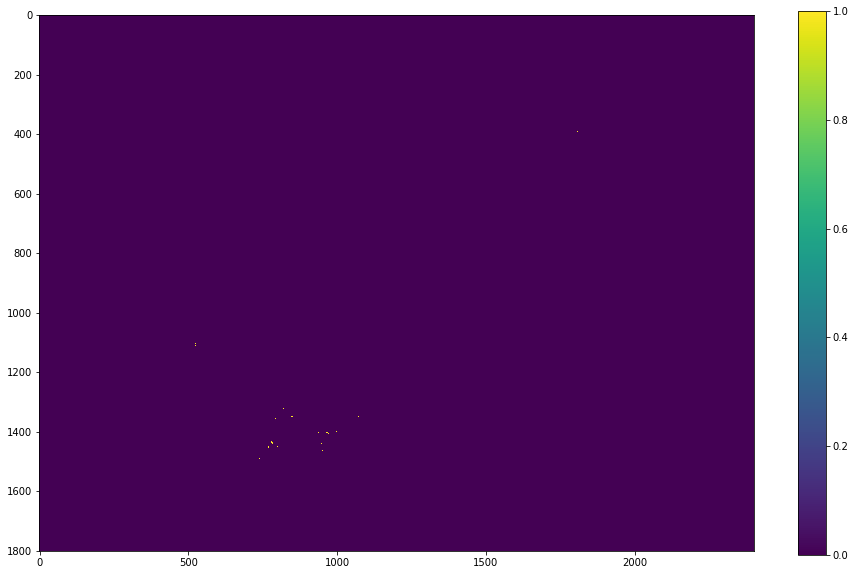

In [58]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ind_plot = ax.imshow(results['20120728t1155'])
plt.colorbar(ind_plot)